# Loading Data

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import display
pd.options.display.max_columns = None

df1=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')
df2=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')

display(df1.head())
display(df2.head())

Join the two dataset on the 'id' column

In [ ]:
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')
display(df2.head(5))

# Demographic Filtering

They offer generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to users with similar demographic features. Since each user is different , this approach is considered to be too simple. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.

Before getting started with this -

* we need a metric to score or rate movie
* Calculate the score for every movie
* Sort the scores and recommend the best rated movie to the users.

We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes. So, I'll be using IMDB's weighted rating (wr) which is given as :-

<img src="https://image.ibb.co/jYWZp9/wr.png" width="500px">

where,

* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report



In [ ]:
# We already have v(vote_count) and R (vote_average)

# Calculate C
C= df2['vote_average'].mean()
C

V,R,C is available, appropriate value for m is yet to be decided. 
We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.

In [ ]:
m= df2['vote_count'].quantile(0.9)
m

Now that we have all values,
First filter movies that have votes greater than m

In [ ]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

481 Movies have qualified.

Now score these movies based on the formula mentioned earlier and add the values as new column named **'score'** in the dataframe

In [ ]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

Also lets find the most popular movies for the "Trending Now" movies.

In [ ]:
pop = df2.sort_values('popularity',ascending=False).reset_index()[:10]
plt.figure(figsize=(25,10))
plt.barh(pop['original_title'],pop['popularity'], align='center')
plt.xlabel("Popularity")
plt.gca().invert_yaxis()
plt.title("Popular Movies")

# Content Based Filtering

They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

**Based on Plot description**

We will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score. The plot description is given in the overview feature of our dataset.

In [ ]:
df2['overview'].head(5)

Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

In [ ]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

We see that over 20,000 different words were used to describe the 4800 movies in our dataset

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the cosine similarity scores. There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:

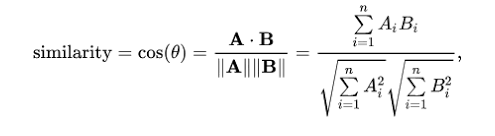

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. 
Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.


In [ ]:
# Import linear_kernel for calculating dot product
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# This creates a 2D matrix of 4803x4803. Every movie is assigned a score with every other movie

We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. 

In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [ ]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

# This creates a movie list with movie name as the index and index number as the value 
# indices['Spectre'] gives output as 2, which is the index of Spectre movie in the original dataframe

We are now in a good position to define our recommendation function. These are the following steps we'll follow :-

* Get the index of the movie given its title.
* Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
* Return the titles corresponding to the indices of the top elements.

In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    # There indices value will be the same index in the original dataset and help us get the movie name from the index
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [ ]:
get_recommendations('The Dark Knight Rises')


In [ ]:
get_recommendations('The Avengers')

While it shows movies that are similar, it does not take into account the similar movies by the same director and so on. This cannot be captured by this system.


**Credits, Genres and Keywords Based**

We are going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords.
 
From the cast, crew and keywords features, we need to extract the three most important actors, the director and the keywords associated with that movie. Right now, our data is present in the form of "stringified" lists , we need to convert it into a safe and usable structure

In [ ]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
# All these above features are present as string, convert them to list of dict objects using literal_eval

for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

Now let's extract required Features from these lists

In [ ]:
print(df2['crew'][0])

In [ ]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

df2['director'] = df2['crew'].apply(get_director)

In [ ]:
print("Keywords")
print(df2['keywords'][0])
print("Cast")
print(df2['cast'][0])
print("Genres")
print(df2['genres'][0])

In [ ]:
# All 3 have the keyword as name. We can write single function

# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)
    
# Print the new features of the first 3 films
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(5)

The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

In [ ]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''
        
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)
    
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(5)

We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords).

In [ ]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

df2[['soup']].head(10)

The next steps are the same as what we did with our plot description based recommender. 

One important difference is that we use the **CountVectorizer()** instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

In [ ]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

# Reset index of our main DataFrame and construct reverse mapping as before
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])

In [ ]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

In [ ]:
get_recommendations('The Godfather', cosine_sim2)

It is more likely that Marvels or DC comics fans will like the movies of the same production house. Therefore, to our features above we can add production_company . 

We can also increase the weight of the director , by adding the feature multiple times in the soup.

# Collaborative Filtering

This system matches persons with similar interests and provides recommendations based on this matching. 
Collaborative filters do not require item metadata like its content-based counterparts.

Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers. It is basically of two types:-

**User based filtering** 

These systems recommend products to a user that similar users have liked. For measuring the similarity between two users we can either use pearson correlation or cosine similarity. This filtering technique can be illustrated with an example. In the following matrixes, each row represents a user, while the columns correspond to different movies except the last one which records the similarity between that user and the target user. Each cell represents the rating that the user gives to that movie. Assume user E is the target.

<img src="https://cdn-images-1.medium.com/max/1000/1*9NBFo4AUQABKfoUOpE3F8Q.png" width="900px">

Since user A and F do not share any movie ratings in common with user E, their similarities with user E are not defined in Pearson Correlation. Therefore, we only need to consider user B, C, and D. Based on Pearson Correlation, we can compute the following similarity.

<img src="https://cdn-images-1.medium.com/max/1000/1*jZIMJzKM1hKTFftHfcSxRw.png" width="900px">

From the above table we can see that user D is very different from user E as the Pearson Correlation between them is negative. He rated Me Before You higher than his rating average, while user E did the opposite. Now, we can start to fill in the blank for the movies that user E has not rated based on other users.

<img src="https://cdn-images-1.medium.com/max/1000/1*9TC6BrfxYttJwiATFAIFBg.png" width="900px">

Although computing user-based CF is very simple, it suffers from several problems. One main issue is that users’ preference can change over time. It indicates that precomputing the matrix based on their neighboring users may lead to bad performance. To tackle this problem, we can apply item-based CF.

**Item Based Collaborative Filtering ** 

Instead of measuring the similarity between users, the item-based CF recommends items based on their similarity with the items that the target user rated. Likewise, the similarity can be computed with Pearson Correlation or Cosine Similarity. The major difference is that, with item-based collaborative filtering, we fill in the blank vertically, as oppose to the horizontal manner that user-based CF does. The following table shows how to do so for the movie Me Before You.

<img src="https://cdn-images-1.medium.com/max/1000/1*LqFnWb-cm92HoMYBL840Ew.png" width="900px">

It successfully avoids the problem posed by dynamic user preference as item-based CF is more static. However, several problems remain for this method. First, the main issue is scalability. The computation grows with both the customer and the product. The worst case complexity is O(mn) with m users and n items. In addition, sparsity is another concern. Take a look at the above table again. Although there is only one user that rated both Matrix and Titanic rated, the similarity between them is 1. In extreme cases, we can have millions of users and the similarity between two fairly different movies could be very high simply because they have similar rank for the only user who ranked them both.


**Single Value Decomposition**

One way to handle the scalability and sparsity issue created by CF is to leverage a latent factor model to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). The lower the RMSE, the better the performance.

Now talking about latent factor you might be wondering what is it ?It is a broad idea which describes a property or concept that a user or an item have. For instance, for music, latent factor can refer to the genre that the music belongs to. SVD decreases the dimension of the utility matrix by extracting its latent factors. Essentially, we map each user and each item into a latent space with dimension r. Therefore, it helps us better understand the relationship between users and items as they become directly comparable. The below figure illustrates this idea.

<img src="https://cdn-images-1.medium.com/max/800/1*GUw90kG2ltTd2k_iv3Vo0Q.png" width="900px">

Now enough said , let's see how to implement this. Since the dataset we used before did not have userId(which is necessary for collaborative filtering) let's load another dataset. We'll be using the Surprise library to implement SVD.

In [ ]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import KFold, cross_validate
reader = Reader()
ratings = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')
ratings.head()

Note that in this dataset movies are rated on a scale of 5 unlike the earlier one.

In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
kf = KFold(n_splits=5)
kf.split(data)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Let us pick user with user Id 1 and check the ratings she/he has given.


In [ ]:
ratings[ratings['userId'] == 1]

In [ ]:
svd.predict(1, 302, 3)

For movie with ID 302, we get an estimated prediction of 2.8. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

We create recommenders using demographic , content- based and collaborative filtering. While demographic filtering is very elemantary and cannot be used practically, Hybrid Systems can take advantage of content-based and collaborative filtering as the two approaches are proved to be almost complimentary.

Refereces:

* https://hackernoon.com/introduction-to-recommender-system-part-1-collaborative-filtering-singular-value-decomposition-44c9659c5e75
* https://www.kaggle.com/rounakbanik/movie-recommender-systems
* http://trouvus.com/wp-content/uploads/2016/03/A-hybrid-movie-recommender-system-based-on-neural-networks.pdf